# Simple Backtrader project
## In this project, we will make a simple strategy and backtest it on Apple Inc. Stocks on a 2010-2020 timeframe with data downloaded from Yahoo Finance Data.
### First we start by importing the libraries needed for this project.

In [33]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf # needed for Yahoo Finance Data /// pip install yfinance

%matplotlib inline

#### A Backtrader needs a class for it's strategies, a class must have an initializer and a next() method that includes all the logic for the strategy.

In [34]:
class MaCrossStrategy(bt.Strategy):
    
    def __init__(self):
        # We will use two SMA (Simple Moving Average) indicators for this strategy withs periods of 10 and 50.
        ma_fast = bt.ind.SMA(period = 10)
        ma_slow = bt.ind.SMA(period = 50)
        # Our strategy is to keep an eye out for a crossover of SMA10 and SMA50
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
               
    def next(self):
        # We will implement the logic of our strategy
        if not self.position:
            # If we are not yet in the market and SMA10 crosses over SMA50
            # We will set a buy order.
            if self.crossover > 0:
                self.buy()
            # If we are already in the market and SMA10 runs below SMA50
            # We will close any of our open trades.
        elif self.crossover < 0:
            self.close()
        

#### Cerebro is the engine of Backtrader library.
#### Cerebro class serves a central point for:
##### - Gathering all inputs (Data Feeds, Strategies, Observers, Analyzers and Writers)
##### - Executes the backtesting or live data trading.
##### - Returns the results
##### - Gives access to the plotting facilities

In [35]:
# First step is to get the engine running
cerebro = bt.Cerebro()

#### Now that our engine is running, it needs some data to feed on.
#### Data from Yahoo Finance Data is being added by a helper library "yfinance" and we are using Pandas DataFrame as the feed source.
#### We can see the deprecated way of importing Yahoo Finance Data commented on top.
#### For the datafeed we need to set the stock ticker, start date and end date.

In [36]:
# data = bt.feeds.YahooFinanceData(dataname = 'AAPL', fromdate = datetime(2010, 1, 1), todate = datetime(2020, 1, 1))   ** DEPRECATED **
data = bt.feeds.PandasData(dataname = yf.download('AAPL', '2010-01-01', '2020-01-01'))
cerebro.adddata(data)

[*********************100%***********************]  1 of 1 completed


#### We add our previously created strategy class for the engine.

In [37]:
cerebro.addstrategy(MaCrossStrategy)

0

#### Broker lets us set a initial cash amount for backtesting purposes.

In [38]:
cerebro.broker.setcash(100000.0)

#### Backtrader includes several different sizers so we can define how much we want to buy per trade.
#### By default, the sizer is set to buy only one share per trade.
##### We are setting a percentage of our previously set cash amount to use in trades.

In [39]:
cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)

#### We have several different analyzers we can use to analyze our strategy.

In [40]:
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(btanalyzers.Transactions, _name = 'transactions')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name = 'trades')

#### Time to run the backtest!

In [41]:
back = cerebro.run()

#### Getting the final amount of cash we ended up with, seems like we would've profited almost 20%!
#### Not too good ROI for 10 years of trading...

In [42]:
cerebro.broker.getvalue()

119221.51850040957

#### Lets dive into the metrics provided by our analyzers...

In [43]:
back[0].analyzers.sharpe.get_analysis()

OrderedDict([('sharperatio', 0.3382110262742297)])

In [44]:
back[0].analyzers.transactions.get_analysis()

OrderedDict([(datetime.datetime(2010, 8, 2, 0, 0),
              [[1088.43537414966,
                9.30142879486084,
                0,
                '',
                -10124.004130460778]]),
             (datetime.datetime(2010, 8, 17, 0, 0),
              [[-1088.43537414966,
                8.931428909301758,
                0,
                '',
                9721.283166586949]]),
             (datetime.datetime(2010, 9, 14, 0, 0),
              [[1044.3094080616527,
                9.507499694824219,
                0,
                '',
                -9928.771378448224]]),
             (datetime.datetime(2011, 3, 21, 0, 0),
              [[-1044.3094080616527,
                11.999643325805664,
                0,
                '',
                12531.340418523074]]),
             (datetime.datetime(2011, 5, 3, 0, 0),
              [[826.3820572211142,
                12.428214073181152,
                0,
                '',
                -10270.453113379845]])

In [45]:
back[0].analyzers.trades.get_analysis()

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 30),
                                   ('open', 1),
                                   ('closed', 29)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 3),
                                                     ('longest', 3)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 4)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      14707.911511990294),
                                                     ('average',
                                                      507.16936248242394)])),
                                   ('net',
                           

#### Cerebro also has a built-in method to plot the whole backtesting process on the charts!
#### Cerebro plotting uses the matplotlib facilities.

<IPython.core.display.Javascript object>


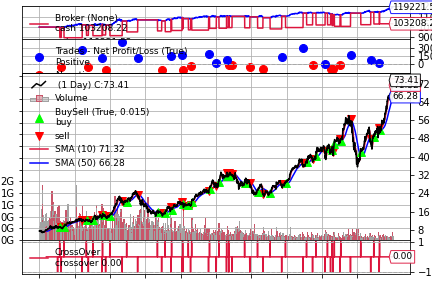

[[<Figure size 432x288 with 5 Axes>]]

In [46]:
cerebro.plot()